<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/week4_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
from tqdm.notebook import tqdm
import torchvision
from torchvision import transforms

### Load dataset

In [2]:
class Cifar10(torchvision.datasets.CIFAR10):
  def __init__(self, train: bool):
    super().__init__(root='~/data', train=train, download=True)
    self.data = self.data.astype(np.float32) / 255 - 0.5

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]

data_train = Cifar10(train=True)
data_test = Cifar10(train=False)

x_train = np.array(data_train.data)
x_test = np.array(data_test.data)

# Reshape
d_data = np.prod(x_train.shape[1:])  # 32 * 32 * 3
x_train = x_train.reshape((-1, d_data))  # (50000, d_data)
x_test = x_test.reshape((-1, d_data))  # (10000, d_data)

y_train = np.array(data_train.targets)
y_test = np.array(data_test.targets)

# Convert y indices to one-hot, 10 classes
y_train = sklearn.preprocessing.label_binarize(y_train, classes=range(10))
y_test = sklearn.preprocessing.label_binarize(y_test, classes=range(10))

# Store samples in columns
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

# Use single precision for speed
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Report shapes
print(f'x_train/y_train shape: {x_train.shape}/{y_train.shape}')
print(f'x_test/y_test shape: {x_test.shape}/{y_test.shape}')

100%|██████████| 170498071/170498071 [00:01<00:00, 90334163.70it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified
x_train/y_train shape: (3072, 50000)/(10, 50000)
x_test/y_test shape: (3072, 10000)/(10, 10000)


### Lets define some helper functions first

In [3]:
def softmax(x):
  x = x - np.max(x, axis=0, keepdims=True)
  ex = np.exp(x)
  return ex / np.sum(ex, axis=0, keepdims=True)

def negative_log_likelihood(yhat, y, eps=1e-9):
  return -np.sum(y * np.log(yhat + eps)) / y.shape[1]

def classification_rate(logits, y):
  return np.mean(np.argmax(logits, axis=0) == np.argmax(y, axis=0))

### Now, lets define Activation layer and Loss function

In [4]:
class ReLU:
  x = None

  def forward(self, x):
    self.x = x
    y = np.maximum(x, 0)
    return y

  def backward(self, dldy):
    # note that the jacobian is a diagonal matrix, since ReLU is applied elementwise
    # we can thus simply express the jacobian as the diagonal vector
    dydx = self.x > 0  # (one where x > 0, else 0)
    dldx = dldy * dydx  # chain rule
    return dldx


class MultinomialCrossEntropyLoss:
  y, yhat = None, None

  def forward(self, logits, y):
    self.y = y
    self.yhat = softmax(logits)
    return negative_log_likelihood(self.yhat, y)

  def backward(self):
    dldlogits = (self.yhat - self.y) / self.y.shape[1]
    return dldlogits

In [10]:
class MLP:
  def __init__(self, n_hidden: int):
    # Weights and biases to learn

    b = np.sqrt(1 / d_data)
    self.W1 = np.random.uniform(-b, b, size=(n_hidden, d_data)).astype(np.float32)
    self.b1 = np.random.uniform(-b, b, size=(n_hidden, 1)).astype(np.float32)

    b = np.sqrt(1 / n_hidden)
    self.W2 = np.random.uniform(-b, b, size=(10, n_hidden)).astype(np.float32)
    self.b2 = np.random.uniform(-b, b, size=(10, 1)).astype(np.float32)

    # and placeholders for their gradients
    self.dldW1, self.dldb1, self.dldW2, self.dldb2 = None, None, None, None

    # Activations and hiddens/outputs to be computed in forward() and to be used in backward()
    self.x, self.a1, self.h = None, None, None

    # Activation function for hidden layer
    self.relu = ReLU()

  '''
  Forward pass: given a (d_data, batch_size) data matrix in, return a (10, batch_size) output logits using weights and biases
  Remember to store x and h to be used in backward() later
  '''
  def forward(self, x, verbose=False):
    self.x = x
    self.a1 = self.W1 @ x + self.b1
    self.h = self.relu.forward(self.a1)
    logits = self.W2 @ self.h + self.b2

    if verbose:
      print('x:', x.shape)
      print('W1:', self.W1.shape)
      print('b1:', self.b1.shape)
      print('h:', self.h.shape)
      print('W2:', self.W2.shape)
      print('b2:', self.b2.shape)
      print('logits:', logits.shape)

    return logits

  '''
  Backward pass: given dldlogits, backprop the gradient to all the weights and biases (dldb1, dldW1, dldb2, dldW2)
  Remember to utilize the activations/hiddens stored in the forward() call and the self.relu.backward call
  Pay attention to the shape of the gradients
  '''
  def backward(self, dldlogits):
    self.dldW2 = dldlogits @ self.h.T
    self.dldb2 = np.sum(dldlogits, axis=1, keepdims=True)
    dldh = self.W2.T @ dldlogits
    dlda1 = self.relu.backward(dldh)
    self.dldW1 = dlda1 @ self.x.T
    self.dldb1 = np.sum(dlda1, axis=1, keepdims=True)

mlp = MLP(n_hidden=100)
logits = mlp.forward(x_train, verbose=True)
mlp.backward(logits)

x: (3072, 50000)
W1: (100, 3072)
b1: (100, 1)
h: (100, 50000)
W2: (10, 100)
b2: (10, 1)
logits: (10, 50000)


### Nows lets define dataloder function that will help us to easily load the data given the batch size

In [11]:
def dataloader(x, y, batch_size: int, shuffle=True):
  idx = np.arange(x.shape[1])
  if shuffle:
    np.random.shuffle(idx)
  n_batches = int(np.ceil(x.shape[1] / batch_size))
  for i in range(n_batches):
    idx_batch = idx[i * batch_size: (i + 1) * batch_size]
    yield x_train[:, idx_batch], y_train[:, idx_batch]

In [18]:
mlp = MLP(n_hidden=100)
loss_fun = MultinomialCrossEntropyLoss()

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# mini batch gradient descent
lr = 0.01
batch_size = 50
epochs = 50

pbar = tqdm(range(epochs))
for epoch in pbar:
  epoch_losses = []
  correct = 0
  for x, y in dataloader(x_train, y_train, batch_size):

    # forward pass: calculate logits and loss
    logits = mlp.forward(x)
    loss = loss_fun.forward(logits, y)
    logits = loss_fun.backward()

    # backward pass: back propagate the loss gradient to your weights
    mlp.backward(logits)

    # stats
    epoch_losses.append(loss)
    correct += np.sum(np.argmax(logits, 0) == np.argmax(y, 0))

    # and update them with the learning rate
    mlp.W1 -= lr * mlp.dldW1
    mlp.b1 -= lr * mlp.dldb1
    mlp.W2 -= lr * mlp.dldW2
    mlp.b2 -= lr * mlp.dldb2

  train_losses.append(np.mean(epoch_losses))
  # train_accuracies.append(correct / x_train.shape[1])
  train_accuracies.append(np.mean(np.argmax(logits, 0) == np.argmax(y_train, 0)))

  # we're using the test set as a validation set here
  logits = mlp.forward(x_test)
  valid_losses.append(loss_fun.forward(logits, y_test))
  valid_accuracies.append(np.mean(np.argmax(logits, 0) == np.argmax(y_test, 0)))

  # update progress bar
  pbar.set_description(f'acc: {train_accuracies[-1]:.2f}/{valid_accuracies[-1]:.2f}')

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-18-8f4ab8648d11>:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  train_accuracies.append(np.mean(np.argmax(logits, 0) == np.argmax(y_train, 0)))


### Finally visualize the results

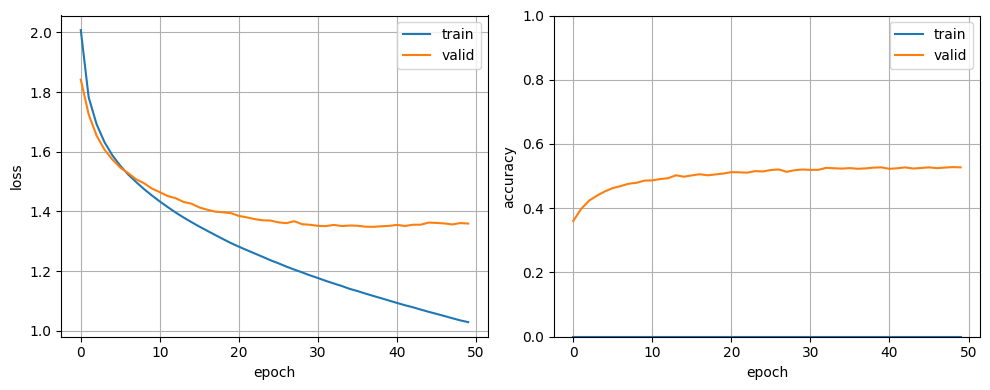

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.ylim(0, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()